In [1]:

# Two-class MNIST 
import math
import os
import tqdm
os.environ['KERAS_BACKEND'] = 'theano'
import keras
from keras.datasets import mnist
import numpy as np

d1 = 5
d2 = 6

(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()

X_train = (mnist_x_train.astype('float32') / 255.).reshape((len(mnist_x_train), np.prod(mnist_x_train.shape[1:])))
y_train = mnist_y_train
X_test = (mnist_x_test.astype('float32') / 255.).reshape((len(mnist_x_test), np.prod(mnist_x_test.shape[1:])))
y_test = mnist_y_test

X_train = X_train[np.logical_or(y_train == d1, y_train == d2)]
y_train = y_train[np.logical_or(y_train == d1, y_train == d2)]
y_train[y_train==d1] = 0
y_train[y_train==d2] = 1
X_test = X_test[np.logical_or(y_test == d1, y_test == d2)]
y_test = y_test[np.logical_or(y_test == d1, y_test == d2)]
y_test[y_test==d1] = 0
y_test[y_test==d2] = 1

print X_train.shape
print X_test.shape

Using Theano backend.


(11339L, 784L)
(1850L, 784L)


In [2]:
from sklearn.metrics import accuracy_score
def metric(y,t):
    return accuracy_score(np.around(y.flat), t)

In [3]:
class Layer():

    def forward_pass(self, input):
        # return output
        raise NotImplementedError()

    def backward_pass(self, input, output_grad):
        # return input_grad, weight_grad
        raise NotImplementedError()

    def update_weights(self, delta_weights):
        pass

    def debug_grad(self, evaluate_loss):
        return None


In [4]:
# Optimizers

class Optimizer():

    def calculate_deltas(self, grad):
        raise NotImplementedError()

class GD(Optimizer):

    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def calculate_deltas(self, grad):
        return -self.learning_rate * grad

class Momentum(Optimizer):
    def __init__(self, alpha, beta):
        self.alpha=alpha
        self.beta=beta
        self.z=0
        
    def calculate_deltas(self, grad):
        self.z=self.beta*self.z+grad
        return -self.alpha*self.z

In [156]:
class Sigmoid(Layer):
    #Modyfikacja do cross entropi
    def sigm(sefl,x):
        #if x>10:#by nie musieć liczyć exp od bardzo małej liczby
            #return 1.0/(1.0+(math.exp(-10)))
        #if x<-10:
            #return 1.0/(1.0+(math.exp(10)))
        return 1.0/(1.0+(math.exp(-x)))
    def derivative(self,x):
        return self.sigm(x)*(1-self.sigm(x))              
    def forward_pass(self, input):
        #print "eLo"
        #print input.shape
        #print input[0][0]
        #print input.shape
        #print input.shape
        #print input
        #print [[x.item ()for x in batch]for batch in input]
        sigm = np.vectorize(self.sigm) 
        return sigm(input)

    def backward_pass(self, input, output_grad):
        derivative = np.vectorize(self.derivative) 
        #print input.shape
        deriv=derivative(input)
        return np.multiply(deriv,output_grad),None

In [9]:
# Funkcje kosztu

class Loss():

    def forward_pass(self, y, t):
        # return cost
        raise NotImplementedError()

    def backward_pass(self, y, t):
        # return y_grad
        raise NotImplementedError()

class MSE(Loss):

    def forward_pass(self, y, t):
        return np.average(0.5 * np.square(y - t))

    def backward_pass(self, y, t):
        return (y - t) / y.size


In [10]:
class Crossentropy(Loss):

    def forward_pass(self, y, t):
       # print t
       # print y
       # print np.log(y)
       # print -t*np.log(y)
       # print -np.multiply(t,np.log(y))-np.multiply((1-t),np.log(1-y))
        #print np.average(-np.multiply(t,np.log(y))-np.multiply((1-t),np.log(1-y)))
        return np.average(-np.multiply(t,np.log(y))-np.multiply((1-t),np.log(1-y)))
        
    def backward_pass(self, y, t):
        # Ćwiczenie 5
        return (-np.divide(t,y)+np.divide((1-t),(1-y)))/ y.size

In [126]:
class ReLU(Layer):
    def f(sefl,x):
        #print x
        if x <=0:
            return 0
        else:
            return x
    def derivative(self,x):
            return x>0
    def forward_pass(self, input):
        maximum = np.vectorize(self.f,otypes=[np.float])
        #print maximum(np.array([[-2.,-3.,412.,1.,43.]]))
        #print input
        #print maximum(input)
        #print maximum(np.array(input))
        #print input
        #output=np.array([[max(x,0) for x in y] for y in input])
        #print lol
        #print output
        return maximum(input)#output
        
        
    def backward_pass(self, input, output_grad):
        derivative = np.vectorize(self.derivative) 
        #print input.shape
        deriv=derivative(input)
        return np.multiply(deriv,output_grad),None

In [321]:
class Dense(Layer):

    def __init__(self, input_size, output_size, init = 'gaussian',viev_norm=0):
        input_size += 1
        self.norm_grad=[]
        self.viev_norm=viev_norm
        print init=='zeros'
        if init =='zeros':
            self.weights = np.zeros((input_size, output_size))
        elif init == 'ones':
            self.weights = np.ones((input_size, output_size))
        elif init == 'gaussian':
            self.weights = np.random.normal(
                0.,
                2. / (input_size + output_size),
                (input_size, output_size)
            )
        elif init == 'stupid':
            self.weights = np.zeros((input_size, output_size))
            self.weights[0][0] = 21.
            self.weights[0][0] = -21.
            #raise NotImplementedError()            
        else:
            raise NotImplementedError()
        self.weights = np.asmatrix(self.weights)

    def forward_pass(self, input):
        input=[np.append(1,batch)  for batch in input]
        return np.dot(input,self.weights)
    
    def backward_pass(self, input, output_grad):
        # Ćwiczenie 1
        #print "wejsciowy grad",output_grad
        input=[np.append(1,batch)  for batch in input]
        P=np.transpose(self.weights)
        #print P.shape
        input_grad=np.dot(output_grad,np.transpose(self.weights))
        #print input,output_grad
        weight_grad=np.zeros(self.weights.shape)
        i=0
        for batch in input:  
            X=batch.reshape(len(batch),1)

            p=output_grad[i].reshape(1,-1)
            
            weight_grad=weight_grad+np.dot(X,p)
            #print weight_grad
            i=i+1
        return input_grad[:,1:], weight_grad.flat
    
    def update_weights(self, delta_weights):
        # Ćwiczenie 7 - monitorowanie normy wektora delta_weights
        if self.viev_norm == 1:
            self.norm_grad.append(np.array(np.abs(delta_weights)).max())
        #print np.array(np.abs(delta_weights)).max()
        self.weights += delta_weights.reshape(self.weights.shape)

    def debug_grad(self, evaluate_loss):
        base = evaluate_loss()
        grad = []
        for (x, y), w in np.ndenumerate(self.weights):
            self.weights[x, y] = w + 0.0001
            changed = evaluate_loss()
            grad.append(10000. * (changed - base))
            self.weights[x, y] = w
        return grad

In [277]:
class Network():

    def __init__(self, loss, optimizer, metrics = []):
        self.layers = []
        self.loss = loss
        self.optimizer = optimizer
        self.metrics = metrics

    def add(self, layer):
        self.layers.append(layer)

    def fit(self, X, t, epochs, batch_size=256, print_stats=False):
        X = np.array(X)
        t = np.array(t)
        X = X.reshape(len(X), -1)
        t = t.reshape(len(t), -1)
        if X.shape[0] != t.shape[0]:
            raise ValueError("Array sizes don't match")
        for epoch in range(epochs):
            if print_stats:
                print("Epoch %d" % (epoch+1))
                print("    -> batch size: %d" % batch_size)
            rng_state = np.random.get_state()
            np.random.shuffle(X)
            #print X
            np.random.set_state(rng_state)
            np.random.shuffle(t)
            pos = 0
            while pos < len(X):
                batch_X = X[pos:pos+batch_size]
                batch_t = t[pos:pos+batch_size]
                self._fit_on_batch(batch_X, batch_t)
                pos += batch_size
            if print_stats:
                _, y = self._forward_pass(X)
                l = self.loss.forward_pass(y, t)
                print("    -> loss: %f" % l)
                for m in self.metrics:
                    print("    -> %s: %f" % (m.__name__, m(y, t)))

    def predict(self, X):
        inps, out = self._forward_pass(X)
        return out

    def _fit_on_batch(self, batch_X, batch_t):
        inps, out = self._forward_pass(batch_X)
        layer_grads = self._backward_pass(
            inps,
            self.loss.backward_pass(out, batch_t)
        )
        grad = self._join(layer_grads)
        deltas = self.optimizer.calculate_deltas(grad)
        for l, d in zip(self.layers, self._split(deltas, layer_grads)):
            if not d is None:
                l.update_weights(d)

    def _join(self, grads):
        #print [g for g in grads if not g is None]
        return np.concatenate([g for g in grads if not g is None])

    def _split(self, grads, layer_grads):
        out = []
        start = 0
        for l in layer_grads:
            if l is None:
                out.append(None)
            else:
                out.append(grads[start:start+len(l)])
                start += len(l)
        return out

    def _forward_pass(self, X):
        inps = []
        output = None
        for layer in self.layers:
            inps.append(X)
            X=layer.forward_pass(X)

        # Ćwiczenie 2
        return inps, X
    def _backward_pass(self, inps, grad):
        n = len(self.layers)
        #print grad.shape
        weight_grad = [None for i in xrange(n)]
        for i in reversed(range(n-1)):
            
            #print i
            #print self.layers[i].backward_pass(inps[i], grad  )
            #print self.layers[i].__class__.__name__
            #print "input:", inps[i]
            #print "grad:" ,grad
            #print "layer"+str(i)
            
            grad, weights_grad = self.layers[i].backward_pass(inps[i], grad  ) 
            #print "wagi", np.array(weights_grad)
            weight_grad[i] =  weights_grad
        return weight_grad
    def _backward_pass2(self, inps, grad):
        n = len(self.layers)
        #print grad.shape
        weight_grad = [None for i in xrange(n)]
        for i in reversed(range(n)):
            
            #print i
            #print self.layers[i].backward_pass(inps[i], grad  )
            #print self.layers[i].__class__.__name__
            #print "input:", inps[i]
            #print "grad:" ,grad
            #print "layer"+str(i)
            print "klasa" ,i
            print self.layers[i].__class__.__name__
            
            grad, weights_grad = self.layers[i].backward_pass(inps[i], grad  ) 
            #print "wagi", np.array(weights_grad)
            weight_grad[i] =  weights_grad
        return weight_grad
    def _debug_grads(self, X, t):
        layer_grads = []
        for l in self.layers:
            g = l.debug_grad(
                lambda: self.loss.forward_pass(self._forward_pass(X)[1], t)
            )
            if not g is None:
                g = np.array(np.array(g).flat)
            layer_grads.append(g)
        return layer_grads

Assert zad1

In [307]:
np.random.seed(43)
d1 = Dense(input_size=4, output_size=3, init="gaussian")
d2 = Dense(input_size=4, output_size=3, init="zeros")

s = Sigmoid()
inp = np.random.random(4).reshape((1,-1)) - 0.5
out_grad_4 = np.random.random(4).reshape((1,-1)) - 0.5
out_grad_3 = np.random.random(3).reshape((1,-1)) - 0.5

print "inp:"
print inp.shape
print inp
print "out_grad_4:"
print out_grad_4.shape
print out_grad_4
print "out_grad_3:"
print out_grad_3.shape
print out_grad_3

print "Testing d1..."
print "d1.forward_pass(inp):"
t = d1.forward_pass(inp)
print t.shape
print t
print "d1.backward_pass(inp, out_grad_3):"
t = d1.backward_pass(inp, out_grad_3)
print t[0].shape
print t[0]
print np.array(t[1]).shape
print np.array(t[1])



False
True
inp:
(1L, 4L)
[[-0.05424164  0.16972465 -0.41749995  0.39709858]]
out_grad_4:
(1L, 4L)
[[-0.2019965  -0.23769518 -0.49487045  0.04320252]]
out_grad_3:
(1L, 3L)
[[-0.02440363  0.13637368  0.47820413]]
Testing d1...
d1.forward_pass(inp):
(1L, 3L)
[[-0.02707048 -0.20288487 -0.03403094]]
d1.backward_pass(inp, out_grad_3):
(1L, 4L)
[[-0.01685764  0.21647157  0.04530229  0.03971692]]
(15L,)
[-0.02440363  0.13637368  0.47820413  0.00132369 -0.00739713 -0.02593858
 -0.0041419   0.02314597  0.08116303  0.01018852 -0.056936   -0.1996502
 -0.00969065  0.05415379  0.18989418]


In [308]:
print "Testing d2..."
print "d2.forward_pass(inp):"
t = d2.forward_pass(inp)
print t.shape
print t
print "d2.backward_pass(inp, out_grad_3):"
t = d2.backward_pass(inp, out_grad_3)
print t[0].shape
print t[0]
print np.array(t[1]).shape
print np.array(t[1])


Testing d2...
d2.forward_pass(inp):
(1L, 3L)
[[ 0.  0.  0.]]
d2.backward_pass(inp, out_grad_3):
(1L, 4L)
[[ 0.  0.  0.  0.]]
(15L,)
[-0.02440363  0.13637368  0.47820413  0.00132369 -0.00739713 -0.02593858
 -0.0041419   0.02314597  0.08116303  0.01018852 -0.056936   -0.1996502
 -0.00969065  0.05415379  0.18989418]


In [309]:
r = ReLU()
print "Testing r..."
print "r.forward_pass(inp):"
t = r.forward_pass(inp)
print t.shape
print t
print "r.backward_pass(inp, out_grad_4):"
t = r.backward_pass(inp, out_grad_4)
print t[0].shape
print t[0]
print t[1]

print "Testing s..."
print "s.forward_pass(inp):"
t = s.forward_pass(inp)
print t.shape
print t
print "s.backward_pass(inp, out_grad_4):"
t = s.backward_pass(inp, out_grad_4)
print t[0].shape
print t[0]
print t[1]

Testing r...
r.forward_pass(inp):
(1L, 4L)
[[ 0.          0.16972465  0.          0.39709858]]
r.backward_pass(inp, out_grad_4):
(1L, 4L)
[[-0.         -0.23769518 -0.          0.04320252]]
None
Testing s...
s.forward_pass(inp):
(1L, 4L)
[[ 0.48644291  0.5423296   0.39711514  0.59799036]]
s.backward_pass(inp, out_grad_4):
(1L, 4L)
[[-0.050462   -0.05899789 -0.11847926  0.01038579]]
None


Powino być
inp:
(1, 4)
[[-0.05424164  0.16972465 -0.41749995  0.39709858]]
out_grad_4:
(1, 4)
[[-0.2019965  -0.23769518 -0.49487045  0.04320252]]
out_grad_3:
(1, 3)
[[-0.02440363  0.13637368  0.47820413]]
Testing d1...
d1.forward_pass(inp):
(1, 3)
[[-0.02707048 -0.20288487 -0.03403094]]
d1.backward_pass(inp, out_grad_3):
(1, 4)
[[-0.01685764  0.21647157  0.04530229  0.03971692]]
(15,)
[-0.02440363  0.13637368  0.47820413  0.00132369 -0.00739713 -0.02593858
 -0.0041419   0.02314597  0.08116303  0.01018852 -0.056936   -0.1996502
 -0.00969065  0.05415379  0.18989418]
Testing d2...
d2.forward_pass(inp):
(1, 3)
[[ 0.  0.  0.]]
d2.backward_pass(inp, out_grad_3):
(1, 4)
[[ 0.  0.  0.  0.]]
(15,)
[-0.02440363  0.13637368  0.47820413  0.00132369 -0.00739713 -0.02593858
 -0.0041419   0.02314597  0.08116303  0.01018852 -0.056936   -0.1996502
 -0.00969065  0.05415379  0.18989418]
Testing r...
r.forward_pass(inp):
(1, 4)
[[ 0.          0.16972465  0.          0.39709858]]
r.backward_pass(inp, out_grad_4):
(1, 4)
[[ 0.         -0.23769518  0.          0.04320252]]
None
Testing s...
s.forward_pass(inp):
(1, 4)
[[ 0.48644291  0.5423296   0.39711514  0.59799036]]
s.backward_pass(inp, out_grad_4):
(1, 4)
[[-0.050462   -0.05899789 -0.11847926  0.01038579]]
None

Assert zad2

In [310]:
np.random.seed(43)
n = Network(loss=MSE(), optimizer=GD(learning_rate=0.001), metrics=[])
n.add(Dense(input_size=4, output_size=3, init="gaussian"))
n.add(ReLU())
n.add(Dense(input_size=3, output_size=4, init="gaussian"))
n.add(ReLU())
n.add(Dense(input_size=4, output_size=1, init="gaussian"))
n.add(Sigmoid())
inp = np.random.random((2,4)) - 0.5
inps, out = n._forward_pass(inp)

print "inp:"
print inp
for i, inp in enumerate(inps):
    print "inps[" + str(i) + "]:"
    print inp
print "out:"
print out

False
False
False
inp:
[[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
 [ 0.17014516  0.20471561  0.10955987  0.04003446]]
inps[0]:
[[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
 [ 0.17014516  0.20471561  0.10955987  0.04003446]]
inps[1]:
[[ 0.06231216 -0.25663962 -0.11549112]
 [ 0.03836232 -0.10585852 -0.03015728]]
inps[2]:
[[ 0.06231216  0.          0.        ]
 [ 0.03836232  0.          0.        ]]
inps[3]:
[[-0.04493685  0.4840028  -0.15711608 -0.22696511]
 [-0.0396103   0.48391873 -0.15615311 -0.24031931]]
inps[4]:
[[ 0.          0.4840028   0.          0.        ]
 [ 0.          0.48391873  0.          0.        ]]
inps[5]:
[[ 0.29948146]
 [ 0.29947621]]
out:
[[ 0.57431575]
 [ 0.57431447]]


Powino być
inp:
[[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
 [ 0.17014516  0.20471561  0.10955987  0.04003446]]
inps[0]:
[[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
 [ 0.17014516  0.20471561  0.10955987  0.04003446]]
inps[1]:
[[ 0.06231216 -0.25663962 -0.11549112]
 [ 0.03836232 -0.10585852 -0.03015728]]
inps[2]:
[[ 0.06231216  0.          0.        ]
 [ 0.03836232  0.          0.        ]]
inps[3]:
[[-0.04493685  0.4840028  -0.15711608 -0.22696511]
 [-0.0396103   0.48391873 -0.15615311 -0.24031931]]
inps[4]:
[[ 0.          0.4840028   0.          0.        ]
 [ 0.          0.48391873  0.          0.        ]]
inps[5]:
[[ 0.29948146]
 [ 0.29947621]]
out:
[[ 0.57431575]
 [ 0.57431447]]

Assert zad 3

In [311]:
np.random.seed(43)
n = Network(loss=MSE(), optimizer=GD(learning_rate=0.001), metrics=[])
n.add(Dense(input_size=4, output_size=3, init="gaussian"))#1
n.add(ReLU())#2
n.add(Dense(input_size=3, output_size=4, init="gaussian"))#3
n.add(ReLU())#4
n.add(Dense(input_size=4, output_size=1, init="gaussian"))#5
n.add(Sigmoid())#6

inp = np.random.random((2,4)) - 0.5
target = inp[:,0:1]
inps, out = n._forward_pass(inp)
grad = n.loss.backward_pass(out, target)
layer_grads = n._backward_pass2(inps, grad)

print "inp:"
print inp
print "target:"
print target
for i, inp in enumerate(inps):
    print "inps[" + str(i) + "]:"
    print inp
print "out:"
print out
print "grad:"
print grad
for i, grad in enumerate(layer_grads):
    print "layer_grads[" + str(i) + "]:"
    np.division
    print np.array(grad)


False
False
False
klasa 5
Sigmoid
klasa 4
Dense
klasa 3
ReLU
klasa 2
Dense
klasa 1
ReLU
klasa 0
Dense
inp:
[[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
 [ 0.17014516  0.20471561  0.10955987  0.04003446]]
target:
[[ 0.06066317]
 [ 0.17014516]]
inps[0]:
[[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
 [ 0.17014516  0.20471561  0.10955987  0.04003446]]
inps[1]:
[[ 0.06231216 -0.25663962 -0.11549112]
 [ 0.03836232 -0.10585852 -0.03015728]]
inps[2]:
[[ 0.06231216  0.          0.        ]
 [ 0.03836232  0.          0.        ]]
inps[3]:
[[-0.04493685  0.4840028  -0.15711608 -0.22696511]
 [-0.0396103   0.48391873 -0.15615311 -0.24031931]]
inps[4]:
[[ 0.          0.4840028   0.          0.        ]
 [ 0.          0.48391873  0.          0.        ]]
inps[5]:
[[ 0.29948146]
 [ 0.29947621]]
out:
[[ 0.57431575]
 [ 0.57431447]]
grad:
[[ 0.25682629]
 [ 0.20208465]]
layer_grads[0]:
[  2.45711515e-05   0.00000000e+00   0.00000000e+00   2.67516826e-06
   0.00000000e+00   0.00000000e+00   9.94

In [13]:

np.random.seed(43)
opt = Momentum(alpha=0.02, beta=0.99)
grad1 = np.random.random(5)
grad2 = np.random.random(5)
grad3 = np.random.random(5)
opt.calculate_deltas(grad1)
opt.calculate_deltas(grad2)
opt.calculate_deltas(grad3)

print "grad1:"
print grad1
print "grad2:"
print grad2
print "grad3:"
print grad3

print "opt.calculate_deltas(grad1):"
print opt.calculate_deltas(grad1)
print "opt.calculate_deltas(grad2):"
print opt.calculate_deltas(grad2)
print "opt.calculate_deltas(grad3):"
print opt.calculate_deltas(grad3)

grad1:
[ 0.11505457  0.60906654  0.13339096  0.24058962  0.32713906]
grad2:
[ 0.85913749  0.66609021  0.54116221  0.02901382  0.7337483 ]
grad3:
[ 0.39495002  0.80204712  0.25442113  0.05688494  0.86664864]
opt.calculate_deltas(grad1):
[-0.02919466 -0.0529381  -0.0209018  -0.01117572 -0.04443381]
opt.calculate_deltas(grad2):
[-0.04608546 -0.06573052 -0.03151603 -0.01164424 -0.05866444]
opt.calculate_deltas(grad3):
[-0.05352361 -0.08111416 -0.03628929 -0.0126655  -0.07541077]


Assert crossentropy

In [14]:
np.random.seed(43)
ce = Crossentropy()
y = np.random.random(10)
t = np.random.random(10)

print "y:"
print y
print "t:"
print t
print "ce.forward_pass(y,t):"
print ce.forward_pass(y,t)
print "ce.backward_pass(y,t):"
print ce.backward_pass(y,t)

y:
[ 0.11505457  0.60906654  0.13339096  0.24058962  0.32713906  0.85913749
  0.66609021  0.54116221  0.02901382  0.7337483 ]
t:
[ 0.39495002  0.80204712  0.25442113  0.05688494  0.86664864  0.221029
  0.40498945  0.31609647  0.0766627   0.84322469]
ce.forward_pass(y,t):
0.736415962327
ce.backward_pass(y,t):
[-0.27490047 -0.08104869 -0.10469935  0.10054647 -0.24509895  0.5272741
  0.11739401  0.0906406  -0.16913545 -0.05603779]


In [280]:
#Zadanie 4
from sklearn.metrics import accuracy_score
def metric(y,t):
    return accuracy_score(np.around(y.flat), t)
network = Network(loss=MSE(), optimizer=GD(learning_rate=0.1), metrics=[metric])
network.add(Dense(784,1))
network.add(Sigmoid())
network.fit(X_train,y_train, epochs= 15, print_stats=True)

False
Epoch 1
    -> batch size: 256
    -> loss: 0.017706
    -> metric: 0.964371
Epoch 2
    -> batch size: 256
    -> loss: 0.014229
    -> metric: 0.967987
Epoch 3
    -> batch size: 256
    -> loss: 0.012824
    -> metric: 0.970015
Epoch 4
    -> batch size: 256
    -> loss: 0.012118
    -> metric: 0.971161
Epoch 5
    -> batch size: 256
    -> loss: 0.011498
    -> metric: 0.972749
Epoch 6
    -> batch size: 256
    -> loss: 0.011106
    -> metric: 0.973807
Epoch 7
    -> batch size: 256
    -> loss: 0.010794
    -> metric: 0.974425
Epoch 8
    -> batch size: 256
    -> loss: 0.010605
    -> metric: 0.974425
Epoch 9
    -> batch size: 256
    -> loss: 0.010427
    -> metric: 0.974336
Epoch 10
    -> batch size: 256
    -> loss: 0.010194
    -> metric: 0.975042
Epoch 11
    -> batch size: 256
    -> loss: 0.009999
    -> metric: 0.975042
Epoch 12
    -> batch size: 256
    -> loss: 0.009847
    -> metric: 0.975571
Epoch 13
    -> batch size: 256
    -> loss: 0.009707
    -> metric

In [343]:

from sklearn.metrics import accuracy_score
def metric(y,t):
    return accuracy_score(np.around(y.flat), t)
network = Network(loss=MSE(), optimizer=Momentum(0.1,0.1), metrics=[metric])
network.add(Dense(784,1))
network.add(Sigmoid())
network.fit(X_train,y_train, epochs= 15, print_stats=True)

False
Epoch 1
    -> batch size: 256
    -> loss: 0.017151
    -> metric: 0.964459
Epoch 2
    -> batch size: 256
    -> loss: 0.013879
    -> metric: 0.967722
Epoch 3
    -> batch size: 256
    -> loss: 0.012523
    -> metric: 0.970632
Epoch 4
    -> batch size: 256
    -> loss: 0.011776
    -> metric: 0.972308
Epoch 5
    -> batch size: 256
    -> loss: 0.011268
    -> metric: 0.973013
Epoch 6
    -> batch size: 256
    -> loss: 0.010883
    -> metric: 0.974425
Epoch 7
    -> batch size: 256
    -> loss: 0.010633
    -> metric: 0.974689
Epoch 8
    -> batch size: 256
    -> loss: 0.010383
    -> metric: 0.974954
Epoch 9
    -> batch size: 256
    -> loss: 0.010206
    -> metric: 0.975042
Epoch 10
    -> batch size: 256
    -> loss: 0.010098
    -> metric: 0.975042
Epoch 11
    -> batch size: 256
    -> loss: 0.009850
    -> metric: 0.975395
Epoch 12
    -> batch size: 256
    -> loss: 0.009707
    -> metric: 0.975659
Epoch 13
    -> batch size: 256
    -> loss: 0.009529
    -> metric

In [342]:
#zad 7
network = Network(loss=Crossentropy(), optimizer=Momentum(0.001,0.01), metrics=[metric])
network.add(Dense(784,5))
network.add(ReLU())
network.add(Dense(5,1))
network.add(Sigmoid())
network.fit(X_train,y_train, epochs= 10, print_stats=True)

False
False
Epoch 1
    -> batch size: 256
    -> loss: 0.659625
    -> metric: 0.913132
Epoch 2
    -> batch size: 256
    -> loss: 0.628762
    -> metric: 0.900344
Epoch 3
    -> batch size: 256
    -> loss: 0.599071
    -> metric: 0.886233
Epoch 4
    -> batch size: 256
    -> loss: 0.569313
    -> metric: 0.888085
Epoch 5
    -> batch size: 256
    -> loss: 0.538409
    -> metric: 0.898492
Epoch 6
    -> batch size: 256
    -> loss: 0.505897
    -> metric: 0.908105
Epoch 7
    -> batch size: 256
    -> loss: 0.470907
    -> metric: 0.922127
Epoch 8
    -> batch size: 256
    -> loss: 0.433193
    -> metric: 0.932093
Epoch 9
    -> batch size: 256
    -> loss: 0.392383
    -> metric: 0.937120
Epoch 10
    -> batch size: 256
    -> loss: 0.349293
    -> metric: 0.942676


In [344]:
#ReLU jako aktywacja niedziała dobrze z Crossentropy
network = Network(loss=Crossentropy(), optimizer=Momentum(0.1,0.1), metrics=[metric])
network.add(Dense(784,20))
network.add(ReLU())
network.add(Dense(20,1))
network.add(ReLU())
network.fit(X_train,y_train, epochs= 10, print_stats=True)

False
False
Epoch 1
    -> batch size: 256
    -> loss: nan
    -> metric: 0.000000
Epoch 2
    -> batch size: 256
    -> loss: nan
    -> metric: 0.000000
Epoch 3
    -> batch size: 256
    -> loss: nan
    -> metric: 0.000000
Epoch 4
    -> batch size: 256
    -> loss: nan
    -> metric: 0.000000
Epoch 5
    -> batch size: 256
    -> loss: nan
    -> metric: 0.000000
Epoch 6
    -> batch size: 256
    -> loss: nan
    -> metric: 0.000000
Epoch 7
    -> batch size: 256
    -> loss: nan
    -> metric: 0.000000
Epoch 8
    -> batch size: 256
    -> loss: nan
    -> metric: 0.000000
Epoch 9
    -> batch size: 256
    -> loss: nan
    -> metric: 0.000000
Epoch 10
    -> batch size: 256
    -> loss: nan
    -> metric: 0.000000


In [13]:
#zad 7
#Sieć złożona tylko z aktywacji Sigmoidalnych
network = Network(loss=Crossentropy(), optimizer=Momentum(0.01,0.01), metrics=[metric])
network.add(Dense(784,5))
network.add(Sigmoid())
network.add(Dense(5,1))
network.add(Sigmoid())
network.fit(X_train,y_train, epochs= 10, print_stats=True)

False
False
Epoch 1
    -> batch size: 256
    -> loss: 0.687322
    -> metric: 0.852280
Epoch 2
    -> batch size: 256
    -> loss: 0.675358
    -> metric: 0.604727
Epoch 3
    -> batch size: 256
    -> loss: 0.651636
    -> metric: 0.738866
Epoch 4
    -> batch size: 256
    -> loss: 0.606958
    -> metric: 0.900520
Epoch 5
    -> batch size: 256
    -> loss: 0.538568
    -> metric: 0.932622
Epoch 6
    -> batch size: 256
    -> loss: 0.455757
    -> metric: 0.941088
Epoch 7
    -> batch size: 256
    -> loss: 0.373043
    -> metric: 0.947438
Epoch 8
    -> batch size: 256
    -> loss: 0.300504
    -> metric: 0.950878
Epoch 9
    -> batch size: 256
    -> loss: 0.242036
    -> metric: 0.953347
Epoch 10
    -> batch size: 256
    -> loss: 0.196399
    -> metric: 0.956345


Przy problemach gdzie targety są binarne ReLU jako wyjście nie działa dobrze. Jednak Jeżeli byśmy mieli inny problem do rozwiązania (np. aproksymacja funkcji o wartościach dodatnich) to można by było rozważyć jego użycie na końcu sieci

In [339]:
#zadanie 8
#mała sieć
L1=Dense(784,10,viev_norm=1)
L2=Dense(10,1,viev_norm=1)
network = Network(loss=MSE(), optimizer=GD(0.01), metrics=[metric])
network.add(L1)
network.add(Sigmoid())
network.add(L2)
network.add(Sigmoid())
network.fit(X_train,y_train, epochs= 1, print_stats=True)


False
False
Epoch 1
    -> batch size: 256
    -> loss: 0.122253
    -> metric: 0.870976


In [330]:
import matplotlib.pylab as plt # Import podpakietu jako plt
# Magia IPython Notebook :) Pokazuje wykresy w konsoli
%matplotlib inline 

In [331]:
def norm_plot(X):
    plt.plot(range(len(X)), X, 'o-')

Normą Gradientów, którą licze i przedstawiam na wykresie jest norma maximum. Jest ona przeskalowana przez normę nauczania czyli w tym wypadku 0.01. Widać, że dla najbardziej od wyjścia ścian norma ta jest najmniejsza

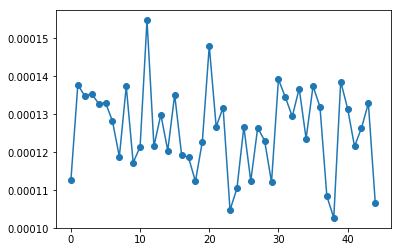

In [340]:
norm_plot(L1.norm_grad)

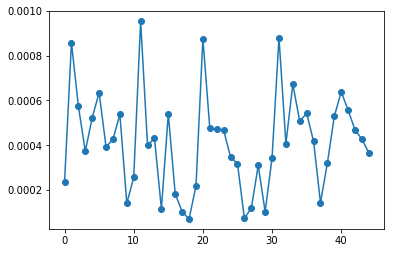

In [341]:
norm_plot(L2.norm_grad)

In [332]:
#6-scio warstwowa sieć
L1=Dense(784,20,viev_norm=1)
L2=Dense(20,10,viev_norm=1)
L3=Dense(10,8,viev_norm=1)
L4=Dense(8,7,viev_norm=1)
L5=Dense(7,2,viev_norm=1)
L6=Dense(2,1,viev_norm=1)
network = Network(loss=MSE(), optimizer=GD(0.01), metrics=[metric])
network.add(L1)
network.add(Sigmoid())
network.add(L2)
network.add(Sigmoid())
network.add(L3)
network.add(Sigmoid())
network.add(L4)
network.add(Sigmoid())
network.add(L5)
network.add(Sigmoid())
network.add(L6)
network.add(Sigmoid())
network.fit(X_train,y_train, epochs= 1, print_stats=True)

False
False
False
False
False
False
Epoch 1
    -> batch size: 256
    -> loss: 0.166418
    -> metric: 0.478084


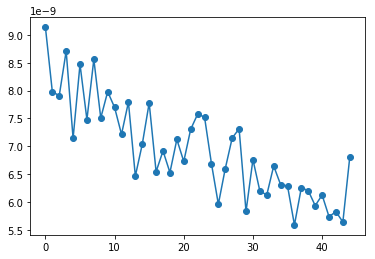

In [333]:
norm_plot(L1.norm_grad)

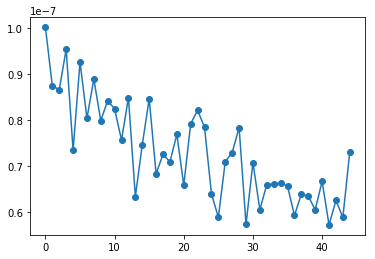

In [334]:
norm_plot(L2.norm_grad)

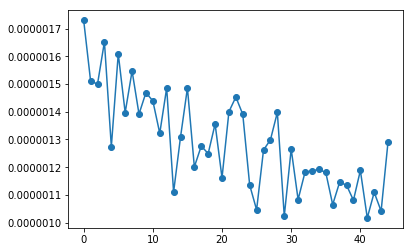

In [335]:
norm_plot(L3.norm_grad)

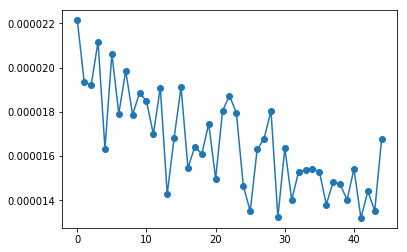

In [336]:
norm_plot(L4.norm_grad)

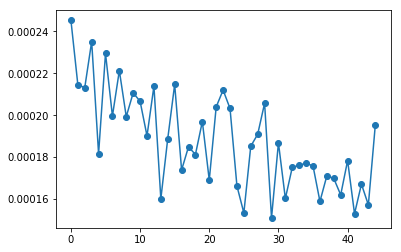

In [337]:
norm_plot(L5.norm_grad)

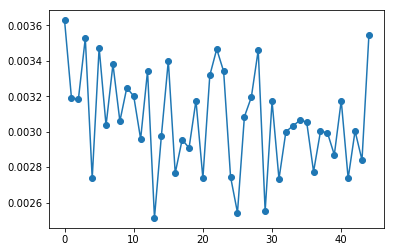

In [338]:
norm_plot(L6.norm_grad)

In [325]:
#bardzo wolno spada funkcja kosztu oraz metric się nie zmienia
network = Network(loss=Crossentropy(), optimizer=Momentum(0.001,0.01), metrics=[metric])
network.add(Dense(784,5,init="stupid"))
network.add(ReLU())
network.add(Dense(5,1,init="gaussian"))
network.add(Sigmoid())
network.fit(X_train,y_train, epochs= 30, print_stats=True)

False
False
Epoch 1
    -> batch size: 256
    -> loss: 0.693510
    -> metric: 0.521916
Epoch 2
    -> batch size: 256
    -> loss: 0.693396
    -> metric: 0.521916
Epoch 3
    -> batch size: 256
    -> loss: 0.693295
    -> metric: 0.521916
Epoch 4
    -> batch size: 256
    -> loss: 0.693194
    -> metric: 0.521916
Epoch 5
    -> batch size: 256
    -> loss: 0.693099
    -> metric: 0.521916
Epoch 6
    -> batch size: 256
    -> loss: 0.693018
    -> metric: 0.521916
Epoch 7
    -> batch size: 256
    -> loss: 0.692939
    -> metric: 0.521916
Epoch 8
    -> batch size: 256
    -> loss: 0.692875
    -> metric: 0.521916
Epoch 9
    -> batch size: 256
    -> loss: 0.692813
    -> metric: 0.521916
Epoch 10
    -> batch size: 256
    -> loss: 0.692758
    -> metric: 0.521916
Epoch 11
    -> batch size: 256
    -> loss: 0.692710
    -> metric: 0.521916
Epoch 12
    -> batch size: 256
    -> loss: 0.692663
    -> metric: 0.521916
Epoch 13
    -> batch size: 256
    -> loss: 0.692623
    -> 

In [327]:
#w przypadku normalnej inicjacji dostajemy normalne dane
network = Network(loss=Crossentropy(), optimizer=Momentum(0.001,0.01), metrics=[metric])
network.add(Dense(784,5,init="gaussian"))
network.add(ReLU())
network.add(Dense(5,1,init="gaussian"))
network.add(Sigmoid())
network.fit(X_train,y_train, epochs= 10, print_stats=True)

False
False
Epoch 1
    -> batch size: 256
    -> loss: 0.677875
    -> metric: 0.478084
Epoch 2
    -> batch size: 256
    -> loss: 0.641048
    -> metric: 0.768057
Epoch 3
    -> batch size: 256
    -> loss: 0.604008
    -> metric: 0.934033
Epoch 4
    -> batch size: 256
    -> loss: 0.566284
    -> metric: 0.932093
Epoch 5
    -> batch size: 256
    -> loss: 0.528931
    -> metric: 0.904489
Epoch 6
    -> batch size: 256
    -> loss: 0.493058
    -> metric: 0.883147
Epoch 7
    -> batch size: 256
    -> loss: 0.460363
    -> metric: 0.868242
Epoch 8
    -> batch size: 256
    -> loss: 0.430995
    -> metric: 0.864362
Epoch 9
    -> batch size: 256
    -> loss: 0.405457
    -> metric: 0.863833
Epoch 10
    -> batch size: 256
    -> loss: 0.384152
    -> metric: 0.864803


In [291]:
z = 1 +1j

In [292]:
z

(1+1j)